In [101]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# 加载预训练模型
model_path = 'TCNmodel/lstm_tcn_model.h5'
pretrained_model = load_model(model_path)

# 冻结更少的层（例如，只冻结前两层）
for layer in pretrained_model.layers[:1]:  
    layer.trainable = False

# 添加新的输出层（根据新任务的需求）
x = pretrained_model.layers[-2].output
new_output = Dense(1, activation='linear')(x)  # 假设是回归任务

# 创建新的模型
new_model = Model(inputs=pretrained_model.input, outputs=new_output)

# 编译新模型
new_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [102]:
# 加载新数据
new_data = pd.read_csv("Fill-1.csv")  # 确保文件名正确

# 检查并处理 NaN 值
if new_data.isnull().values.any():
    print("新数据中存在 NaN 值，正在处理...")
    new_data = new_data.dropna()  # 删除包含 NaN 的行
    # 或者使用 new_data.fillna(new_data.mean(), inplace=True) 填充 NaN

new_inputs = new_data.iloc[:, :2].values
new_output = new_data.iloc[:, 2].values.reshape(-1, 1)

# 加载保存的scaler
scaler_in = joblib.load('scalers/scaler_in.pkl')
scaler_out = joblib.load('scalers/scaler_out.pkl')

# 使用加载的scaler进行归一化
new_inputs = scaler_in.transform(new_inputs)
new_output = scaler_out.transform(new_output)

# 重新调整输入形状
timesteps = 1
new_inputs = new_inputs.reshape((new_inputs.shape[0], timesteps, new_inputs.shape[1]))

# 训练新模型
history = new_model.fit(new_inputs, new_output, epochs=10, batch_size=200, validation_split=0.2)

# 评估新模型
new_predictions = new_model.predict(new_inputs).flatten()
new_output = new_output.flatten()

# 计算指标
new_rmse = np.sqrt(mean_squared_error(new_output, new_predictions))
new_mae = mean_absolute_error(new_output, new_predictions)
new_r2 = r2_score(new_output, new_predictions)

print(f"New RMSE: {new_rmse}, New MAE: {new_mae}, New R²: {new_r2}")


新数据中存在 NaN 值，正在处理...
Epoch 1/10
401/401 [==============================] - 13s 11ms/step - loss: 0.0203 - mae: 0.0463 - val_loss: 0.0015 - val_mae: 0.0348
Epoch 2/10
401/401 [==============================] - 4s 9ms/step - loss: 5.0196e-04 - mae: 0.0153 - val_loss: 0.0014 - val_mae: 0.0315
Epoch 3/10
401/401 [==============================] - 4s 9ms/step - loss: 4.2861e-04 - mae: 0.0136 - val_loss: 0.0011 - val_mae: 0.0281
Epoch 4/10
401/401 [==============================] - 4s 9ms/step - loss: 3.9684e-04 - mae: 0.0127 - val_loss: 0.0012 - val_mae: 0.0290
Epoch 5/10
401/401 [==============================] - 4s 9ms/step - loss: 3.7399e-04 - mae: 0.0121 - val_loss: 0.0011 - val_mae: 0.0274
Epoch 6/10
401/401 [==============================] - 4s 9ms/step - loss: 3.6665e-04 - mae: 0.0118 - val_loss: 0.0012 - val_mae: 0.0284
Epoch 7/10
401/401 [==============================] - 4s 9ms/step - loss: 3.5721e-04 - mae: 0.0115 - val_loss: 9.6199e-04 - val_mae: 0.0239
Epoch 8/10
401/401 [=====

In [103]:
# 保存迁移学习后的模型
new_model_path = 'TCNmodel/lstm_tcn_tl_model_finetuned.h5'
new_model.save(new_model_path)
print(f"Fine-tuned model saved to {new_model_path}")


Fine-tuned model saved to TCNmodel/lstm_tcn_tl_model_finetuned.h5


/root/miniconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


损失图已保存到: lstmtcn_tl_fig/lstm_loss_plot.png
局部放大损失图已保存到: lstmtcn_tl_fig/zoom_loss_plot.png


/tmp/ipykernel_98341/748199914.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: lstmtcn_tl_fig/combined_plot_zoomed.png


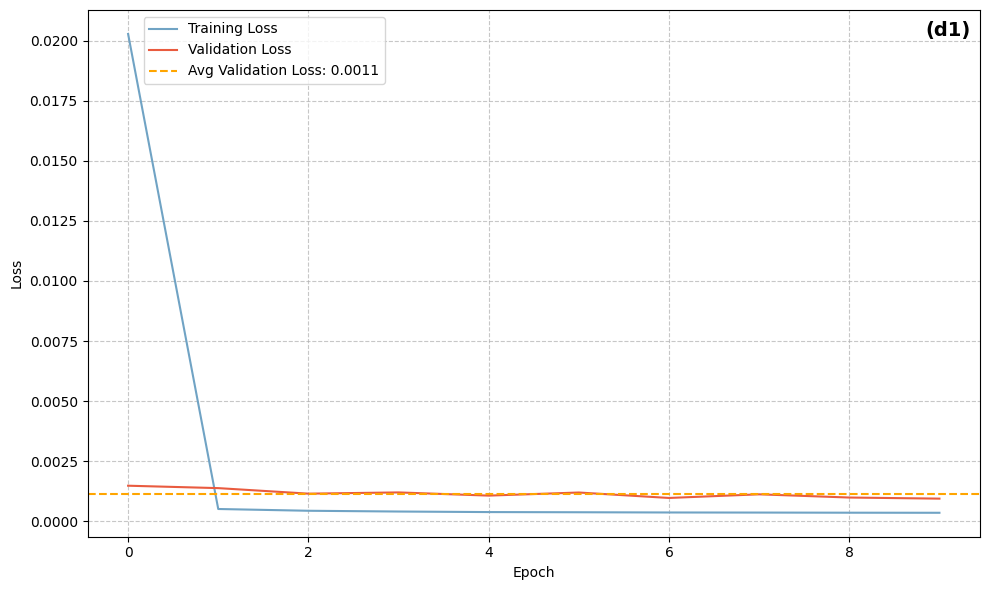

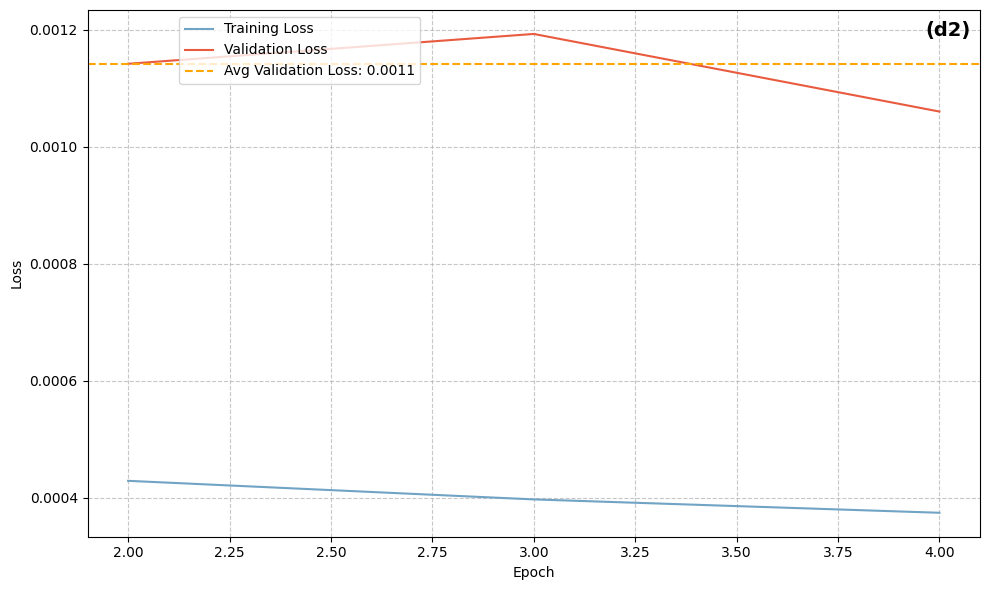

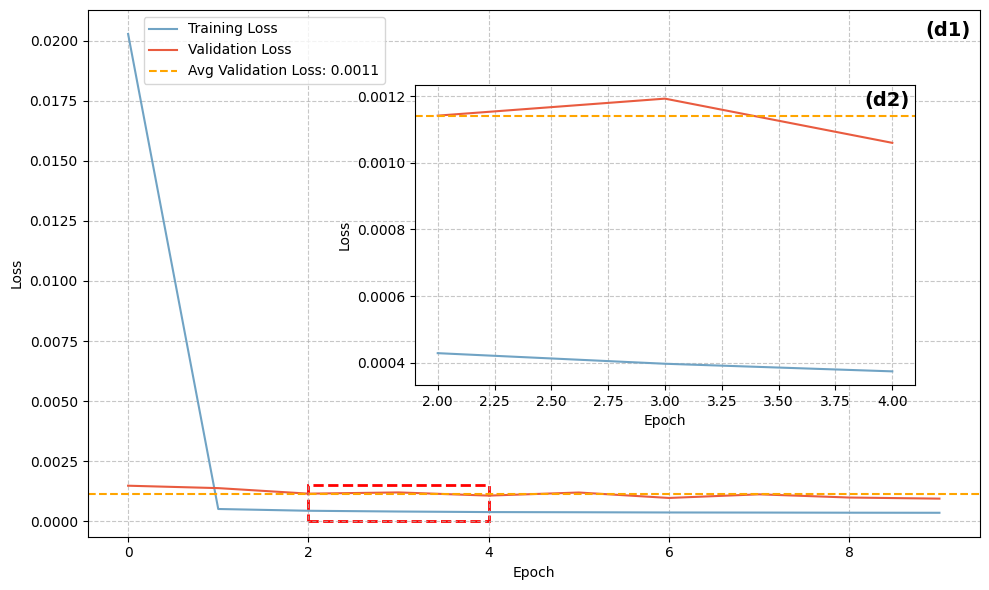

In [104]:
# 创建文件夹保存图像
folder_name = "lstmtcn_tl_fig"
os.makedirs(folder_name, exist_ok=True)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
avg_val_loss = np.mean(val_loss)

# 绘制损失曲线
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(d1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'lstm_loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 手动定义红框区域
red_box_start = 2
red_box_end = 4
red_box_y_min =0
red_box_y_max = 0.0015

# 手动定义放大区域
zoom_epoch_start = 2
zoom_epoch_end = 5

# 绘制局部放大损失曲线
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss[zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss[zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.legend(loc='upper left', bbox_to_anchor=(0.095, 1), bbox_transform=ax2.transAxes)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(d2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# 绘制结合图
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(d1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# Inset zoomed-in loss
inset_ax = fig.add_axes([0.42, 0.35, 0.5, 0.5])
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss[zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss[zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.98, '(d2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 添加红色虚线矩形
rect = plt.Rectangle((red_box_start, red_box_y_min),  # 起始位置 (x, y)
                     red_box_end - red_box_start,  # 宽度
                     red_box_y_max - red_box_y_min,  # 高度
                     edgecolor='red', linestyle='--', linewidth=2, facecolor='none', transform=ax1.transData)

ax1.add_patch(rect)

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'combined_plot_zoomed.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

plt.show()


825/825 [==============================] - 3s 3ms/step


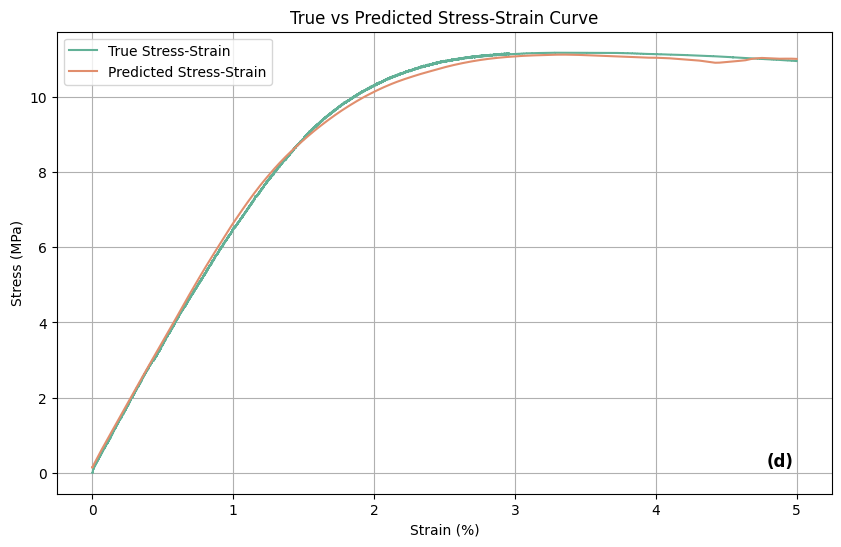

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# 确保保存图片的文件夹存在
folder_path = os.path.join('lstmtcn_tl_fig', 'prediction')
os.makedirs(folder_path, exist_ok=True)

# 加载保存的scaler
scaler_in = joblib.load('scalers/scaler_in.pkl')
scaler_out = joblib.load('scalers/scaler_out.pkl')

# 读取新数据
file_name = '60-p.csv'  # 使用正确的数据集
df_new_data = pd.read_csv(file_name)

# 提取特征和真实值
strain = df_new_data.iloc[:, 1].values  # 假设第二列是应变值
stress_true = df_new_data.iloc[:, 2].values  # 第三列为真实应力值

# 对新数据进行归一化处理
x_new = df_new_data.iloc[:, :2].values  # 取前两列作为输入特征
x_new_scaled = scaler_in.transform(x_new)

# 创建新数据序列
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 1  # 根据之前的模型设置
x_new_seq = create_sequences(x_new_scaled, sequence_length)

# 加载迁移学习后的模型
model_path = os.path.join('TCNmodel', 'lstm_tcn_tl_model_finetuned.h5')
model = load_model(model_path)

# 进行预测
y_pred_scaled = model.predict(x_new_seq)

# 将预测值从三维转换为二维
y_pred_scaled_2d = y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1])

# 将预测值逆归一化，恢复到原始尺度
stress_pred = scaler_out.inverse_transform(y_pred_scaled_2d).flatten()

# 确保预测值和实际值的长度相同
min_length = min(len(strain), len(stress_pred))
strain_truncated = strain[:min_length]
stress_true_truncated = stress_true[:min_length]
stress_pred_truncated = stress_pred[:min_length]

# 过滤应变值小于或等于5的数据
mask = strain_truncated <= 5
strain_filtered = strain_truncated[mask]
stress_true_filtered = stress_true_truncated[mask]
stress_pred_filtered = stress_pred_truncated[mask]

# 绘制预测结果与真实值的对比图
plt.figure(figsize=(10, 6))
plt.plot(strain_filtered, stress_true_filtered, label='True Stress-Strain', color='#62B197')
plt.plot(strain_filtered, stress_pred_filtered, label='Predicted Stress-Strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.legend()
plt.title('True vs Predicted Stress-Strain Curve')
plt.grid(True)
# 在右下角添加文本 (d)
plt.text(0.95, 0.05, '(d)', fontsize=12, fontweight='bold', ha='right', va='bottom', transform=plt.gca().transAxes)
# 保存图片
plt.savefig(os.path.join(folder_path, 'predicted_vs_true_stress_strain.png'))
plt.show()

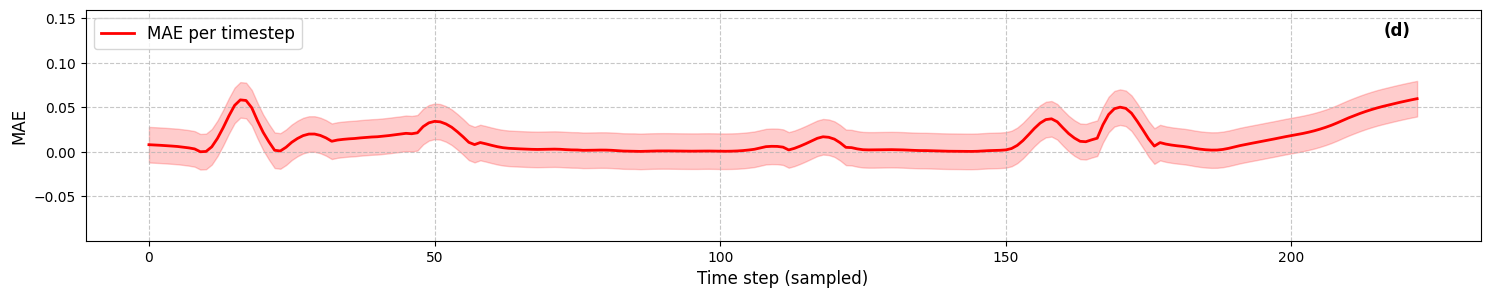

MAE per timestep plot saved and displayed: ./lstmtcn_tl_fig/mae_per_timestep.png


In [119]:
from scipy.signal import savgol_filter

# 计算每个时间步的 MAE
mae_per_timestep = np.abs(new_output - new_predictions)

# 采样数据以减少密度（例如，每隔250个点取一个）
sampling_rate = 450
mae_sampled = mae_per_timestep[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)

# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per timestep', color='red', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.02  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='red', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本 (c)
plt.text(0.95, 0.95, '(d)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)
# 设置Y轴范围
plt.ylim(min(mae_smoothed) - 0.1, max(mae_smoothed) + 0.1)
plt.xlabel('Time step (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 保存图像
mae_timestep_path = './lstmtcn_tl_fig/mae_per_timestep.png'
os.makedirs(os.path.dirname(mae_timestep_path), exist_ok=True)
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per timestep plot saved and displayed: {mae_timestep_path}")
